In [45]:
#import tensorflow as tf
import numpy as np
import pandas as pd
import holidays
import matplotlib.pyplot as plt
from math import sin, cos, sqrt, atan2, radians

%matplotlib inline
holiday_list = holidays.India(years=2016)

In [46]:
train_data = pd.read_csv(r"D:\Narendra\Hitachi data Engineer Challenge\DataSet/train.csv")
test_data = pd.read_csv(r"D:\Narendra\Hitachi data Engineer Challenge\DataSet/test.csv")
columns=train_data.drop(['id_code', 'target'], axis=1).columns
tot_data = pd.concat([train_data[columns], test_data[columns]])

In [47]:
train_data['current_datetime'] = pd.to_datetime(train_data['current_date']+' '+train_data['current_time'])
train_data['datetime'] = pd.to_datetime(train_data['current_date']+' '+train_data['current_time'])
test_data['current_datetime'] = pd.to_datetime(test_data['current_date']+' '+test_data['current_time'])
test_data['datetime'] = pd.to_datetime(test_data['current_date']+' '+test_data['current_time'])

In [48]:
source_station = tot_data[['source_name', 'country_code_source', 'longitude_source', 'latitude_source', 'mean_halt_times_source']]
destination_station = tot_data[['destination_name', 'country_code_destination', 'longitude_destination', 'latitude_destination', 'mean_halt_times_destination']]
source_station.columns=['name', 'country_code', 'latitude', 'longitude', 'mean_halt_times']
destination_station.columns=['name', 'country_code', 'latitude', 'longitude', 'mean_halt_times']

In [49]:
station_detail = pd.concat([source_station, destination_station])
station_detail['id'] = station_detail['name'].apply(lambda x: int(x[8:]))
station_detail = station_detail.drop_duplicates()
station_detail.sort_values('id', inplace=True)
station_detail.reset_index(drop=True, inplace=True)
station_detail = station_detail.fillna(method = 'bfill')
station_detail

,name,country_code,latitude,longitude,mean_halt_times,id
0,station$0,logbp,-0.126061,51.531040,0.000000,0
1,station$1,logbp,-0.126061,51.531040,0.000000,1
2,station$2,logbp,-0.126061,51.531040,0.000000,2
3,station$3,logbp,0.321070,51.443040,0.000000,3
4,station$11,zxdec,6.958823,50.942721,12.540462,11
...,...,...,...,...,...,...
304,station$640,whber,2.999286,50.772072,22.445087,640
305,station$642,whber,2.736343,50.854449,22.445087,642
306,station$643,whber,3.130412,50.949025,35.274566,643
307,station$644,whber,3.212088,50.921149,35.274566,644


In [50]:
station_dict = {}
for x,y in zip(station_detail['name'], station_detail['id']):
    station_dict[x] = y

In [51]:
country_code = station_detail['country_code'].sort_values()
country_code = country_code.drop_duplicates()
country_code.reset_index(drop=True, inplace=True)
country_code = country_code.reset_index(drop=False)
country_code.columns=['id', 'code']
country_code

,id,code
0,0,aqfre
1,1,logbp
2,2,qwnll
3,3,whber
4,4,wsluu
5,5,zxdec


In [52]:
country_dict={}
for x,y in zip(country_code['code'], country_code['id']):
    country_dict[x]=y

In [53]:
train_detail = train_data.loc[:,['id_code', 'current_datetime', 'train_name', 'source_name', 'destination_name', 'target']]
train_detail.drop_duplicates()
train_detail.sort_values('current_datetime', inplace=True)
train_detail.reset_index(drop=True, inplace=True)
train_detail.reset_index(inplace=True)
train_detail.rename(columns={'current_datetime':'datetime', 'index':'train_id', 'target':'passenger_demand', 
                             'source_name':'source', 'destination_name': 'destination'}, inplace=True)
train_detail

,train_id,id_code,datetime,train_name,source,destination,passenger_demand
0,0,isfywypmkqqhyft,2016-07-27 20:05:51,ICZVZS,station$147,station$1,high
1,1,mqsfxyvuqpbwomk,2016-07-27 20:06:11,ICZVZS,station$147,station$1,high
2,2,alspwwtbdvqsgby,2016-07-27 20:08:57,ICZVZS,station$147,station$1,high
3,3,szitxhhqduyrqpg,2016-07-27 20:09:08,ICZVZS,station$147,station$1,high
4,4,krisdqzczivvwcp,2016-07-27 20:11:01,ICZVZS,station$147,station$1,high
...,...,...,...,...,...,...,...
1279,1279,gfnxmbjcdyjdbeo,2016-10-05 15:12:10,ICZVZY,station$130,station$279,medium
1280,1280,mcfgyjeuatomuub,2016-10-05 18:14:27,ICWZZV,station$544,station$266,medium
1281,1281,rwhslfljqeapqhw,2016-10-05 18:23:44,SZZTSS,station$147,station$159,high
1282,1282,xcseqqecaatslst,2016-10-05 18:27:34,ICYAXR,station$147,station$422,low


In [54]:
train_dict = {}
for x,y in zip(train_detail['train_name'], train_detail['train_id']):
    train_dict[x] = y

In [55]:
station_detail['country_code'] = station_detail['country_code'].apply(lambda x: country_dict[x])
train_detail['source'] = train_detail['source'].apply(lambda x: station_dict[x])
train_detail['destination'] = train_detail['destination'].apply(lambda x: station_dict[x])

In [56]:
def get_distance(lat1, lon1, lat2, lon2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c
    return distance

In [57]:
train_data = train_detail.merge(station_detail, left_on='source', right_on='id', how='left')

In [58]:
train_data = train_data.merge(station_detail, left_on='source', right_on='id', how='left', suffixes=('_source', '_destination'))

In [59]:
train_data['distance_between_stations'] = get_distance(train_data['latitude_source'].values, train_data['longitude_source'].values, 
                                                       train_data['latitude_destination'].values, train_data['longitude_destination'].values)

In [60]:
datetime_detail = pd.DataFrame(pd.date_range('2016-06-01', '2016-11-30', freq='s'), columns=['datetime'])
datetime_detail['datetime'] = pd.to_datetime(datetime_detail['datetime'])

In [61]:
datetime_detail['day'] = datetime_detail['datetime'].dt.weekday.astype(int)
datetime_detail['is_weekend']=0
datetime_detail.loc[datetime_detail['day']>4, 'is_weekend']=1
datetime_detail['hours'] = datetime_detail['datetime'].dt.hour.astype(int)
datetime_detail['minutes'] = datetime_detail['datetime'].dt.minute.astype(int)
test_data['hours'] = test_data['datetime'].dt.hour
test_data['minutes'] = test_data['datetime'].dt.month.astype(int)
test_data['is_weekend'] = (test_data['is_weekend']*1).astype(int)

In [62]:
train_data = train_data.merge(datetime_detail, on='datetime', how='left')

In [63]:
train_data

,train_id,id_code,datetime,train_name,source,destination,passenger_demand,name_source,country_code_source,latitude_source,...,country_code_destination,latitude_destination,longitude_destination,mean_halt_times_destination,id_destination,distance_between_stations,day,is_weekend,hours,minutes
0,0,isfywypmkqqhyft,2016-07-27 20:05:51,ICZVZS,147,1,high,station$147,3,4.356801,...,3,4.356801,50.845658,634.164740,147,0.0,2,0,20,5
1,1,mqsfxyvuqpbwomk,2016-07-27 20:06:11,ICZVZS,147,1,high,station$147,3,4.356801,...,3,4.356801,50.845658,634.164740,147,0.0,2,0,20,6
2,2,alspwwtbdvqsgby,2016-07-27 20:08:57,ICZVZS,147,1,high,station$147,3,4.356801,...,3,4.356801,50.845658,634.164740,147,0.0,2,0,20,8
3,3,szitxhhqduyrqpg,2016-07-27 20:09:08,ICZVZS,147,1,high,station$147,3,4.356801,...,3,4.356801,50.845658,634.164740,147,0.0,2,0,20,9
4,4,krisdqzczivvwcp,2016-07-27 20:11:01,ICZVZS,147,1,high,station$147,3,4.356801,...,3,4.356801,50.845658,634.164740,147,0.0,2,0,20,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1279,1279,gfnxmbjcdyjdbeo,2016-10-05 15:12:10,ICZVZY,130,279,medium,station$130,3,4.360846,...,3,4.360846,50.859663,640.265896,130,0.0,2,0,15,12
1280,1280,mcfgyjeuatomuub,2016-10-05 18:14:27,ICWZZV,544,266,medium,station$544,3,3.710675,...,3,3.710675,51.035896,309.014451,544,0.0,2,0,18,14
1281,1281,rwhslfljqeapqhw,2016-10-05 18:23:44,SZZTSS,147,159,high,station$147,3,4.356801,...,3,4.356801,50.845658,634.164740,147,0.0,2,0,18,23
1282,1282,xcseqqecaatslst,2016-10-05 18:27:34,ICYAXR,147,422,low,station$147,3,4.356801,...,3,4.356801,50.845658,634.164740,147,0.0,2,0,18,27


columns = train_data.columns
train_columns = columns.drop(['id_code', 'target', 'current_date', 'current_time', 'current_year'])
categoricals = ['source_name', 'destination_name', 'train_name', 'country_code_source', 'country_code_destination', 'current_week', 
                'current_day', 'is_weekend', 'season', 'hour', 'current_month', 'is_holiday']

In [67]:
train_data.isna().sum()

train_id                       0
id_code                        0
datetime                       0
train_name                     0
source                         0
destination                    0
passenger_demand               0
name_source                    0
country_code_source            0
latitude_source                0
longitude_source               0
mean_halt_times_source         0
id_source                      0
name_destination               0
country_code_destination       0
latitude_destination           0
longitude_destination          0
mean_halt_times_destination    0
id_destination                 0
distance_between_stations      0
day                            0
is_weekend                     0
hours                          0
minutes                        0
high                           0
medium                         0
low                            0
dtype: int64

In [65]:
train_data['high'] = np.where(train_data['passenger_demand']=='high', 1, 0)
train_data['medium'] = np.where(train_data['passenger_demand']=='medium', 1, 0)
train_data['low'] = np.where(train_data['passenger_demand']=='low', 1, 0)

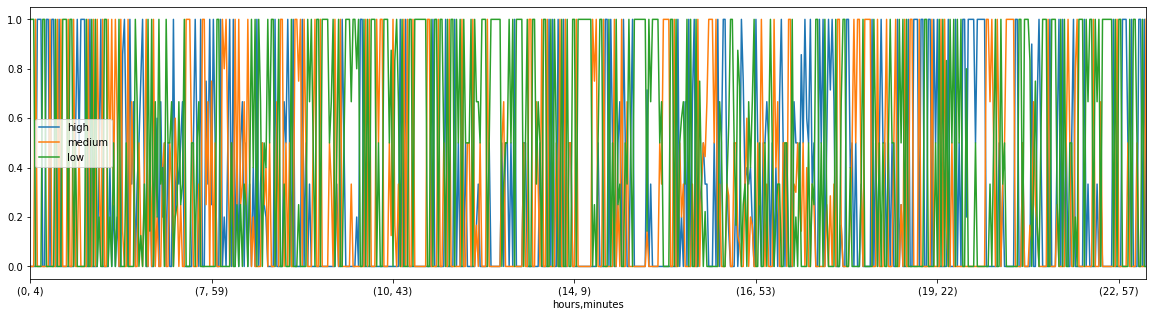

In [68]:
train_data.groupby(['hours', 'minutes'])['high', 'medium', 'low'].mean().plot(figsize=(20,5))

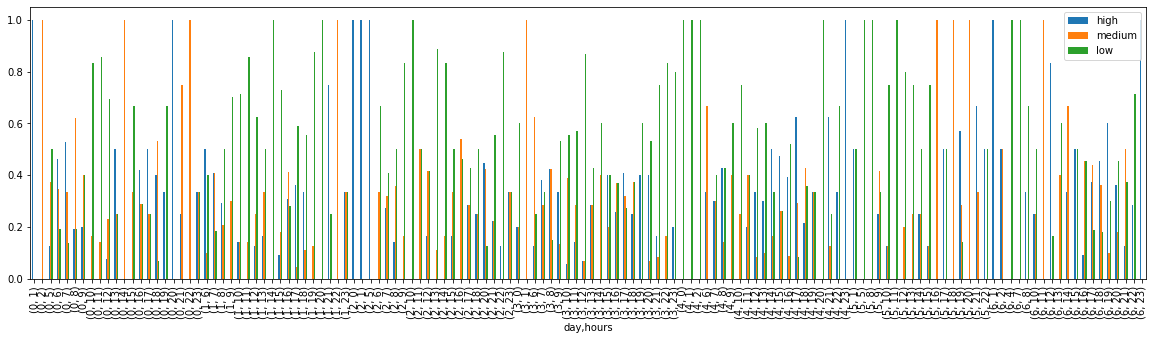

In [70]:
train_data.groupby(['day', 'hours'])['high', 'medium', 'low'].mean().plot.bar(figsize=(20,5))

In [71]:
X = train_data[['hours', 'minutes', 'day']]
Y = np.where(train_data['passenger_demand']=='high', 0, np.where(train_data['passenger_demand']=='medium',1, 2))

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.4, stratify=Y)

In [72]:
train_data.shape

(1284, 27)

In [73]:
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier()
dt_clf.fit(x_train, y_train)
print(dt_clf.score(x_train, y_train))
print(dt_clf.score(x_test, y_test))

0.9298701298701298
0.45136186770428016


In [74]:
from sklearn.metrics import confusion_matrix, f1_score
print(confusion_matrix(dt_clf.predict(x_test), y_test))
print(f1_score(dt_clf.predict(x_test), y_test, average='macro'))

[[79 57 68]
 [41 55 47]
 [37 32 98]]
0.4455792884007194


In [69]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier()
rf_clf.fit(x_train, y_train)
print(rf_clf.score(x_train, y_train))
print(rf_clf.score(x_test, y_test))

0.6467532467532467
0.4727626459143969


D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [70]:
print(confusion_matrix(rf_clf.predict(x_test), y_test))
print(f1_score(rf_clf.predict(x_test), y_test, average='macro'))

[[ 71  53  40]
 [ 37  38  39]
 [ 49  53 134]]
0.4446077348559572


In [71]:
from sklearn.ensemble import ExtraTreesClassifier
et_clf = ExtraTreesClassifier()
et_clf.fit(x_train, y_train)
print(et_clf.score(x_train, y_train))
print(et_clf.score(x_test, y_test))

0.6584415584415585
0.46303501945525294


D:\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [72]:
print(confusion_matrix(et_clf.predict(x_test), y_test))
print(f1_score(et_clf.predict(x_test), y_test, average='macro'))

[[ 68  59  45]
 [ 53  41  39]
 [ 36  44 129]]
0.44025904954391176


In [73]:
from sklearn.neighbors import KNeighborsClassifier 
knn = KNeighborsClassifier(n_neighbors = 6)
knn.fit(x_train, y_train)
print(knn.score(x_train, y_train))
print(knn.score(x_test, y_test))

0.5597402597402598
0.4455252918287938


In [74]:
print(confusion_matrix(knn.predict(x_test), y_test))
print(f1_score(knn.predict(x_test), y_test, average='macro'))

[[ 64  41  56]
 [ 56  47  39]
 [ 37  56 118]]
0.4292636085088915


In [75]:
test_pred = dt_clf.predict(x_test)
test_pred = np.vstack((test_pred, rf_clf.predict(x_test)))
test_pred = np.vstack((test_pred, et_clf.predict(x_test)))
test_pred = np.vstack((test_pred, knn.predict(x_test)))
test_pred = test_pred.T

In [76]:
result=[]
for row in range(len(test_pred)):
    low=0
    high=0
    medium=0
    if test_pred[row][0]==0:
        high+=1
    elif test_pred[row][0]==1:
        medium+=1
    else:
        low+=1
    if test_pred[row][0]==0:
        high+=1
    elif test_pred[row][0]==1:
        medium+=1
    else:
        low+=1
    if test_pred[row][0]==0:
        high+=1
    elif test_pred[row][0]==1:
        medium+=1
    else:
        low+=1
    if low>high and low>medium:
        res = 2
    elif high>low and high>medium:
        res=0
    else:
        res=1
    result.append(res)

In [77]:
print(f1_score(result, y_test, average='macro'))

0.43375219247334124


In [83]:
test_pred = dt_clf.predict(test_data[['hours', 'minutes', 'current_day', 'is_holiday']])
test_pred = np.vstack((test_pred, rf_clf.predict(test_data[['hours', 'minutes', 'current_day', 'is_holiday']])))
test_pred = np.vstack((test_pred, et_clf.predict(test_data[['hours', 'minutes', 'current_day', 'is_holiday']])))
test_pred = np.vstack((test_pred, knn.predict(test_data[['hours', 'minutes', 'current_day', 'is_holiday']])))
test_pred = test_pred.T

In [84]:
result=[]
for row in range(len(test_pred)):
    low=0
    high=0
    medium=0
    if test_pred[row][0]==0:
        high+=1
    elif test_pred[row][0]==1:
        medium+=1
    else:
        low+=1
    if test_pred[row][0]==0:
        high+=1
    elif test_pred[row][0]==1:
        medium+=1
    else:
        low+=1
    if test_pred[row][0]==0:
        high+=1
    elif test_pred[row][0]==1:
        medium+=1
    else:
        low+=1
    if low>high and low>medium:
        res = 2
    elif high>low and high>medium:
        res=0
    else:
        res=1
    result.append(res)

In [85]:
result = np.array(result).astype(int)
print(np.unique(result, return_counts=True))

(array([0, 1, 2]), array([420, 281, 263], dtype=int64))


In [86]:
submission = {}
submission['id_code'] = test_data['id_code']
submission['target'] = np.where(result==0, 'high', np.where(result==1, 'medium', 'low'))
submission=pd.DataFrame(submission)

In [87]:
print(np.unique(submission['target'], return_counts=True))

(array(['high', 'low', 'medium'], dtype=object), array([420, 263, 281], dtype=int64))


In [88]:
submission.to_csv(r"D:\Narendra\Hitachi data Engineer Challenge\DataSet/submission.csv", index=False)

In [90]:
#currently Top
result = et_clf.predict(test_data[['hours', 'minutes', 'current_day', 'is_holiday']])
submission = {}
submission['id_code'] = test_data['id_code']
submission['target'] = np.where(result==0, 'high', np.where(result==1, 'medium', 'low'))
submission=pd.DataFrame(submission)

In [91]:
#currently Top
print(np.unique(submission['target'], return_counts=True))
submission.to_csv(r"D:\Narendra\Hitachi data Engineer Challenge\DataSet/submission.csv", index=False)

(array(['high', 'low', 'medium'], dtype=object), array([418, 313, 233], dtype=int64))
